# The final model
 

## Model v2.0

In [1]:
model_name = f'3.33-v2.0'

In [2]:
import warnings

from sklearn.metrics import root_mean_squared_error

warnings.filterwarnings("ignore")

In [3]:
import pandas as pd
from data import load_data

_, augmented_data, test_data = load_data()

In [4]:
augmented_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 174940 entries, p01_test_12 to p24_test_95514
Columns: 507 entries, p_num to bg+1:00
dtypes: float64(433), object(74)
memory usage: 682.1+ MB


In [5]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3644 entries, p01_8459 to p24_260
Columns: 506 entries, p_num to activity-0:00
dtypes: float64(432), object(74)
memory usage: 14.2+ MB


# Prepare the data

In [6]:
from pipelines import pipeline

train_data_transformed = pipeline.fit_transform(augmented_data)

X_train = train_data_transformed.drop(columns=['bg+1:00'])
y_train = train_data_transformed['bg+1:00']

## Predict for validation data and check results

In [7]:
import dnns
from tensorflow.keras.optimizers import Adam
from scikeras.wrappers import KerasRegressor

create_dnn_model = dnns.create_model_MA01


def model_with_pretrained_weights():
    dnn = create_dnn_model(X_train.shape[1])
    dnn.load_weights(f'{model_name}.weights.h5')  # Load the pre-trained weights

    # Freeze all layers except the last one (optional)
    for layer in dnn.layers:
        layer.trainable = False
    # Unfreeze the output layer if you want to fine-tune it
    # dnn.layers[-1].trainable = True

    dnn.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mse',
        metrics=[dnns.rmse]
    )
    return dnn


Epoch 1/100
4374/4374 - 6s - 1ms/step - loss: 11.4195 - rmse: 3.0710 - val_loss: 6.0199 - val_rmse: 2.1357
Epoch 2/100
4374/4374 - 5s - 1ms/step - loss: 5.9990 - rmse: 2.4157 - val_loss: 5.5754 - val_rmse: 2.0626
Epoch 3/100
4374/4374 - 5s - 1ms/step - loss: 5.6885 - rmse: 2.3519 - val_loss: 5.5415 - val_rmse: 2.0613
Epoch 4/100
4374/4374 - 5s - 1ms/step - loss: 5.4897 - rmse: 2.3091 - val_loss: 5.6985 - val_rmse: 2.0820
Epoch 5/100
4374/4374 - 4s - 853us/step - loss: 5.3189 - rmse: 2.2743 - val_loss: 5.5109 - val_rmse: 2.0587
Epoch 6/100
4374/4374 - 3s - 727us/step - loss: 5.1735 - rmse: 2.2418 - val_loss: 5.4352 - val_rmse: 2.0386
Epoch 7/100
4374/4374 - 4s - 880us/step - loss: 5.0957 - rmse: 2.2241 - val_loss: 5.6749 - val_rmse: 2.0825
Epoch 8/100
4374/4374 - 4s - 834us/step - loss: 5.0091 - rmse: 2.2059 - val_loss: 5.4374 - val_rmse: 2.0416
Epoch 9/100
4374/4374 - 4s - 897us/step - loss: 4.9410 - rmse: 2.1910 - val_loss: 5.4604 - val_rmse: 2.0494
Epoch 10/100
4374/4374 - 5s - 1ms/s

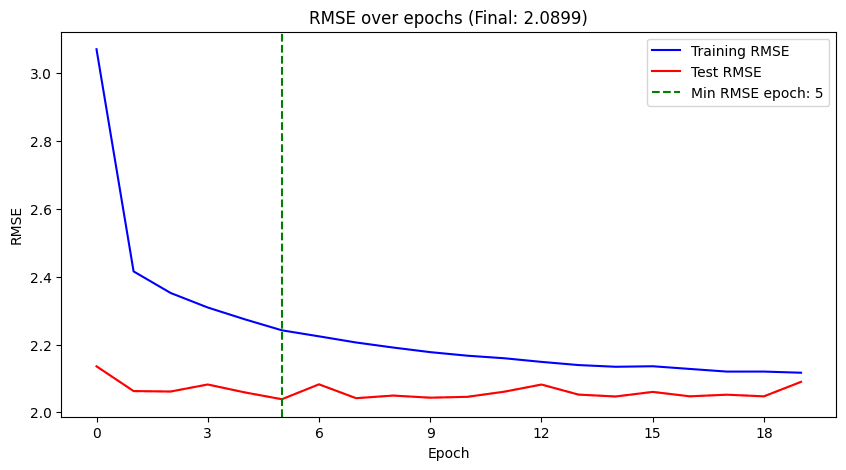

In [8]:
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import StackingRegressor, HistGradientBoostingRegressor
from sklearn.linear_model import LassoLarsIC, Ridge
from tensorflow.keras.callbacks import EarlyStopping
from model_performance_calculations import get_history_line_chart

# pretrain the DNN and use the weights in the stacking model
pretrained_dnn = create_dnn_model(X_train.shape[1])
pretrained_dnn.fit(
    X_train,
    y_train,
    epochs=100,
    verbose=2,
    validation_split=0.2,
    batch_size=32,
    callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]
)

history = pretrained_dnn.history.history
pretrained_dnn.save_weights(f'{model_name}.weights.h5')

keras_regressor = KerasRegressor(
    model=model_with_pretrained_weights,
    epochs=1,
    verbose=2
)

estimators = [
    ('hgb', HistGradientBoostingRegressor(max_iter=1000, max_depth=5, learning_rate=0.01)),
    ('xgb', XGBRegressor(objective='reg:squarederror', random_state=42, n_estimators=5000, max_depth=5, learning_rate=0.01)),
    ('knn', KNeighborsRegressor(n_neighbors=5)),
    ('lasso', LassoLarsIC(criterion='bic', max_iter=5000)),
    ('dnn', keras_regressor)
]

model = StackingRegressor(estimators=estimators, final_estimator=Ridge(alpha=0.1), n_jobs=1, verbose=2)

get_history_line_chart([history]).show()

15:25:26 - Start training
15:25:26 - Calculate performance for hgb
15:25:26 - Split 1 - Model: hgb
15:25:26 - Fitting the model
15:26:18 - Predicting
15:26:19 - Calculating scores
15:26:19 - R^2: 0.5770155121432432, RMSE: 2.077239049923198, MAE: 1.5437328993196546, MSE: 4.31492207052583
15:26:19 - Split 2 - Model: hgb
15:26:19 - Fitting the model
15:27:57 - Predicting
15:27:57 - Calculating scores
15:27:57 - R^2: 0.5733497540906529, RMSE: 2.0994787183945665, MAE: 1.558310478153361, MSE: 4.407810888991691
15:27:57 - Split 3 - Model: hgb
15:27:57 - Fitting the model
15:28:19 - Predicting
15:28:20 - Calculating scores
15:28:20 - R^2: 0.5794120250211829, RMSE: 2.0701886801301175, MAE: 1.5369130773470907, MSE: 4.285681171338878
15:28:20 - Split 4 - Model: hgb
15:28:20 - Fitting the model
15:28:37 - Predicting
15:28:38 - Calculating scores
15:28:38 - R^2: 0.5781129776950211, RMSE: 2.091461413905243, MAE: 1.5512161970338099, MSE: 4.374210845854519
15:28:38 - Split 5 - Model: hgb
15:28:38 - Fi

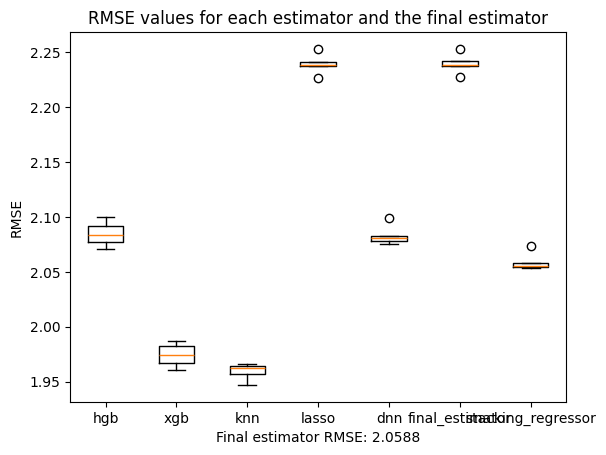

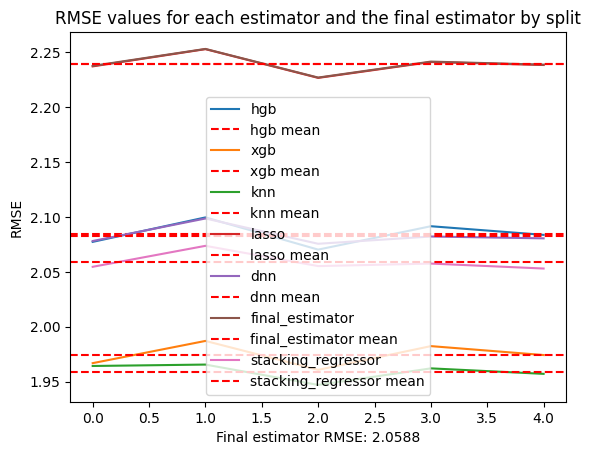

In [9]:
from datetime import datetime
import os
from model_performance_calculations import calculate_stacking_regressor_performance, get_rmse_boxplot_chart, get_rmse_line_chart, save_performances, save_model

date_time = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

save_model(model, os.path.join('models', f'{model_name}.pkl'))

performances = calculate_stacking_regressor_performance(model, X_train, y_train, n_splits=5)
save_performances(performances, os.path.join('models', f'{model_name}-performances.json'))

get_rmse_boxplot_chart(performances).show()
get_rmse_line_chart(performances).show()

In [10]:
import numpy as np
from pipelines import pipeline

train_data_transformed = pipeline.fit_transform(augmented_data)

X_train = train_data_transformed.drop(columns=['bg+1:00'])
y_train = train_data_transformed['bg+1:00']

model.fit(X_train, y_train)

X_test = pipeline.transform(test_data)
y_pred = model.predict(X_test)

if np.sum(y_pred < 0) > 0:
    print(f'Number of negative values: {np.sum(y_pred < 0)}')
    bg_min_train = np.min(y_train)
    print(f'Min value: {np.min(y_pred)}')
    print(f'Filling negative values with {bg_min_train}')
    y_pred = np.where(y_pred < 0, bg_min_train, y_pred)

test_data['bg+1:00'] = y_pred
test_data.head()

5467/5467 - 2s - 317us/step - loss: 4.8203 - rmse: 3.8551
4374/4374 - 2s - 356us/step - loss: 4.6521 - rmse: 3.8452
1094/1094 - 0s - 326us/step
4374/4374 - 1s - 320us/step - loss: 4.9672 - rmse: 3.7626
1094/1094 - 0s - 320us/step
4374/4374 - 1s - 322us/step - loss: 5.0219 - rmse: 3.9392
1094/1094 - 0s - 327us/step
4374/4374 - 1s - 322us/step - loss: 4.9188 - rmse: 3.9449
1094/1094 - 0s - 328us/step
4374/4374 - 1s - 321us/step - loss: 4.5577 - rmse: 3.7617
1094/1094 - 0s - 326us/step
114/114 - 0s - 997us/step


,p_num,time,bg-5:55,bg-5:50,bg-5:45,bg-5:40,bg-5:35,bg-5:30,bg-5:25,bg-5:20,...,activity-0:40,activity-0:35,activity-0:30,activity-0:25,activity-0:20,activity-0:15,activity-0:10,activity-0:05,activity-0:00,bg+1:00
id,,,,,,,,,,,,,,,,,,,,,
p01_8459,p01,06:45:00,NaN,9.2,NaN,NaN,10.2,NaN,NaN,10.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.449201
p01_8460,p01,11:25:00,NaN,NaN,9.9,NaN,NaN,9.4,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Walk,Walk,Walk,6.711266
p01_8461,p01,14:45:00,NaN,5.5,NaN,NaN,5.5,NaN,NaN,5.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.181909
p01_8462,p01,04:30:00,NaN,3.4,NaN,NaN,3.9,NaN,NaN,4.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.654483
p01_8463,p01,04:20:00,NaN,NaN,8.3,NaN,NaN,10.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.246370


In [11]:
submission = pd.DataFrame(test_data['bg+1:00'])
submission

,bg+1:00
id,
p01_8459,8.449201
p01_8460,6.711266
p01_8461,7.181909
p01_8462,11.654483
p01_8463,7.246370
...,...
p24_256,6.323380
p24_257,11.868846
p24_258,6.432147


In [12]:
submission.to_csv(f'submission-model-{model_name}.csv')

In [13]:
y_pred = model.predict(X_train)

root_mean_squared_error(y_train, y_pred)


5467/5467 - 1s - 267us/step


np.float64(2.033169504149753)

In [14]:
from sklearn.metrics import root_mean_squared_error

root_mean_squared_error(y_train, y_pred)

np.float64(2.033169504149753)